# **Project - Medical Treatment**

## **Problem statement**

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

This problem was a competition posted on Kaggle with a award of $15,000. This was launched by  Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track,  because we need your help to take personalized medicine to its full potential.

You can check all details about the competition from following link :
https://www.kaggle.com/c/msk-redefining-cancer-treatment

In order to get the dataset please create a login account to Kaggle and go to this problem statement page(given above) and download 2 dataset

***training_variants.zip*** and ***training_text.zip***

## **Analysis of the problem statement**

Lets first understand the data set provided and using that dataset we will try to understand the above problem in Machine Learning world. Since, the dataset is huge lets load it using python itself.

In [1]:
!pip install mlxtend

In [2]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlxtend

In [3]:
# Loading all required packages
# If any of it fails, do not panic. Just install it using "pip3 install <package_name>" or by using conda install package_name
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

There are 2 data files provided for solving this problem. I have kept them inside a folder training. So lets load them

In [4]:
from google.colab import files
uploaded = files.upload()

Saving training_variants.zip to training_variants.zip


In [5]:
from google.colab import files
uploaded = files.upload()

Saving training_text.zip to training_text.zip


In [6]:
!unzip training_variants.zip

Archive:  training_variants.zip
  inflating: training_variants       


In [7]:
!unzip training_text.zip

Archive:  training_text.zip
  inflating: training_text           


In [8]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training_variants')
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [9]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


Let's understand above data. There are 4 fields above:
- **ID** : row id used to link the mutation to the clinical evidence
- **Gene** : the gene where this genetic mutation is located
- **Variation** : the aminoacid change for this mutations
- **Class** : class value 1-9, this genetic mutation has been classified on
    
Keep doing more analysis  on above data.

In [10]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [11]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [12]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [13]:
# Clecking column in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

Now lets explore about data_text

In [14]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


So above dataset have 2 columns. ID and Text column. We can also observe column ID which is common in both the dataset. Lets keep exploring it.

In [15]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [16]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [17]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [18]:
# checking the dimentions
data_text.shape

(3321, 2)

So, in short my datasets looks like this
 * data_variants (ID, Gene, Variations, Class)
 * data_text(ID, text)

Ok, now we understood the dataset. Lets try to understand the same problem from Machine Learning point of view

We want to predict about class of cancer. Now question is what kind of data is present in class column. 

In [19]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

This is descrete data so it is ***classification*** problem and since there are multiple descrete output possible so we can call it ***Multi class*** classification problem


***Important note*** : This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result  for each class in terms of Probablity. We might not be much bothered about time taken by ML algorithm as far as it is reasonable. 

We also want our model to be highly interpritable because a medical practitionar want to also give proper reasonining on why ML algorithm is predicting any class. 

We will evaluate our model using Confution matrix and Multi class log-loss

Ok, now we understood the problem statement. Let's work on the solution. 

***Note*** I highly recomend you to attempt the solution on your own first. After that come back and enjoy our solution. 

We have huge amount of text data. So, we need to pre process it. So lets write a function for the same.

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
# We would like to remove all stop words like a, is, an, the, ... 
# so we collecting all of them from nltk library
stop_words = set(stopwords.words('english'))

In [22]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [23]:
# Below code will take some time because its huge text (took 4 minute on my 16 GB RAM system), so run it and have a cup of coffee :)
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

Let's merge both the dataset. Remember that ID was common column. So lets use it to merge.

In [24]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


It's very important to look for missing values. Else they create problem in final analysis

In [25]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see many rows with missing data. Now the question is what to do with this missing value. One way could be that we can drop these rows having missing values or we can do some imputation in it. Let's go with imputation only. But question is what to impute here :

How about merging Gene and Variation column. Let's do it:

In [26]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

Let's cross check it once again if there is any missing values

In [27]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


Awesome, so all missing values are gone now.

## Creating Training, Test and Validation data

Before we split the data into taining, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [28]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

Ok, so we can now start our split process in train, test and validation data set.

In [29]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [30]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Let's look at the distribution of data in train, test and validation set.

In [31]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [32]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

So, what does above variable suggest us. This means in my train dataset we have class 1 values with count of 363, class 2 values having count of 289 and so on. It will be better idea to visualise it in graph format.

**Visualizing for train class distrubution**

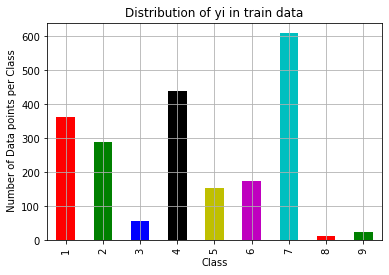

In [33]:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_class_distribution.plot(kind='bar', color = my_colors)
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

Let's look at distribution in form of percentage

In [34]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


Let's visualize the same for test set

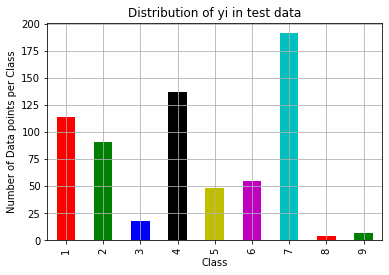

In [35]:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
test_class_distribution.plot(kind='bar', color = my_colors)
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [36]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


Let's visualize for cross validation set

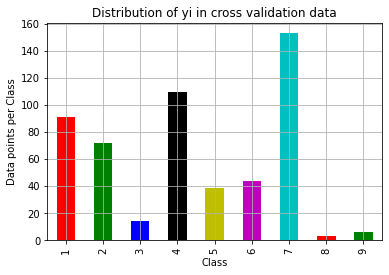

In [37]:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
cv_class_distribution.plot(kind='bar', color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [38]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


Now question is because we need log-loss as final evaluation metrics how do we say that model we are going to build will be good model. For doing this we will build a random model and will evaluate log loss. Our model should return lower log loss value than this. So, what are you waiting for. Always have a bg smile while solving Machine learning problems :). That helps!!

## **Building a Random model**

Ok, so we need to generate 9 random numbers because we have 9 class such that their sum must be equal to 1 because sum of Probablity of all 9 classes must be equivalent to 1.

In [39]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [40]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.425933574046201


In [41]:
# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.4999131568168855


In [42]:
# Lets get the index of max probablity
predicted_y =np.argmax(test_predicted_y, axis=1)

In [43]:
# Lets see the output. these will be 665 values present in test dataset
predicted_y

array([5, 2, 7, 2, 7, 1, 7, 7, 4, 0, 7, 0, 3, 6, 6, 8, 0, 6, 3, 8, 4, 5,
       5, 5, 6, 1, 0, 4, 3, 7, 6, 4, 6, 4, 4, 6, 2, 6, 6, 5, 1, 8, 7, 8,
       0, 7, 8, 2, 0, 1, 5, 5, 6, 3, 7, 0, 2, 6, 3, 8, 1, 3, 8, 0, 1, 5,
       7, 4, 0, 6, 0, 4, 7, 3, 8, 1, 6, 4, 4, 5, 5, 7, 4, 6, 1, 2, 3, 6,
       1, 0, 5, 8, 7, 2, 2, 5, 0, 0, 5, 4, 0, 5, 4, 5, 8, 6, 8, 7, 8, 1,
       2, 7, 0, 1, 5, 1, 6, 2, 1, 2, 4, 4, 7, 3, 6, 4, 8, 4, 2, 5, 7, 5,
       7, 2, 5, 4, 4, 3, 8, 0, 5, 3, 1, 3, 7, 2, 6, 5, 2, 3, 2, 1, 7, 2,
       1, 0, 4, 8, 8, 2, 3, 5, 1, 2, 8, 3, 6, 6, 4, 0, 3, 5, 4, 7, 0, 4,
       8, 2, 0, 6, 5, 2, 6, 3, 0, 6, 4, 2, 4, 0, 6, 4, 8, 0, 4, 2, 2, 8,
       4, 6, 2, 4, 5, 6, 7, 7, 2, 4, 7, 7, 6, 2, 7, 3, 2, 1, 0, 3, 7, 5,
       2, 8, 3, 1, 0, 6, 7, 0, 1, 4, 7, 4, 4, 3, 0, 8, 8, 4, 1, 2, 7, 3,
       7, 6, 1, 2, 5, 5, 8, 2, 8, 2, 1, 6, 7, 6, 8, 3, 6, 7, 3, 2, 3, 2,
       3, 3, 0, 0, 2, 6, 4, 3, 8, 0, 3, 7, 7, 2, 1, 6, 7, 7, 8, 3, 2, 0,
       7, 4, 3, 3, 0, 1, 1, 3, 0, 8, 8, 5, 0, 8, 8,

So you can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [44]:
predicted_y = predicted_y + 1

### **Confusion Matrix**

In [45]:
C = confusion_matrix(y_test, predicted_y)

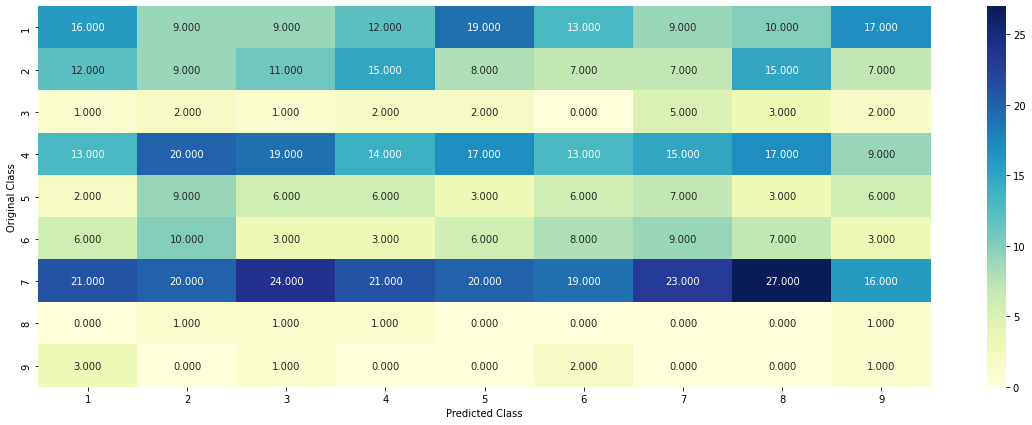

In [46]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### **Precision matrix**

In [47]:
B =(C/C.sum(axis=0))

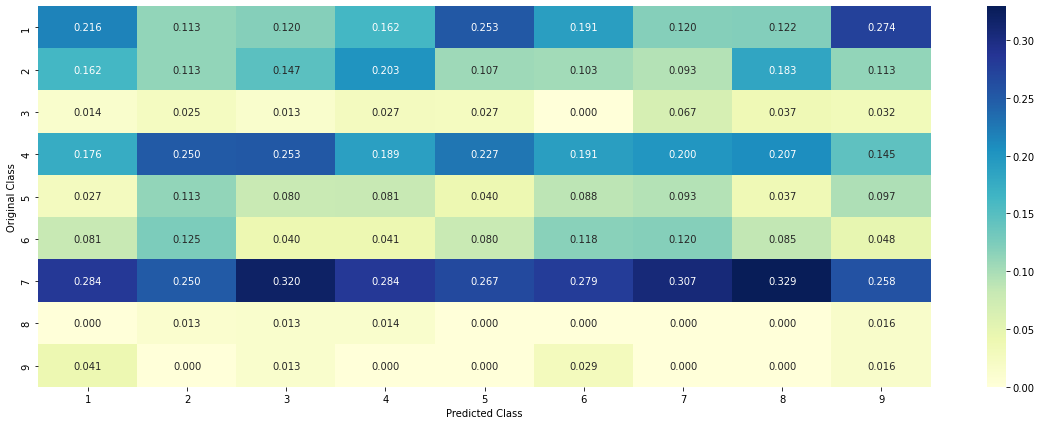

In [48]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### **Recall matrix**

In [49]:
A =(((C.T)/(C.sum(axis=1))).T)

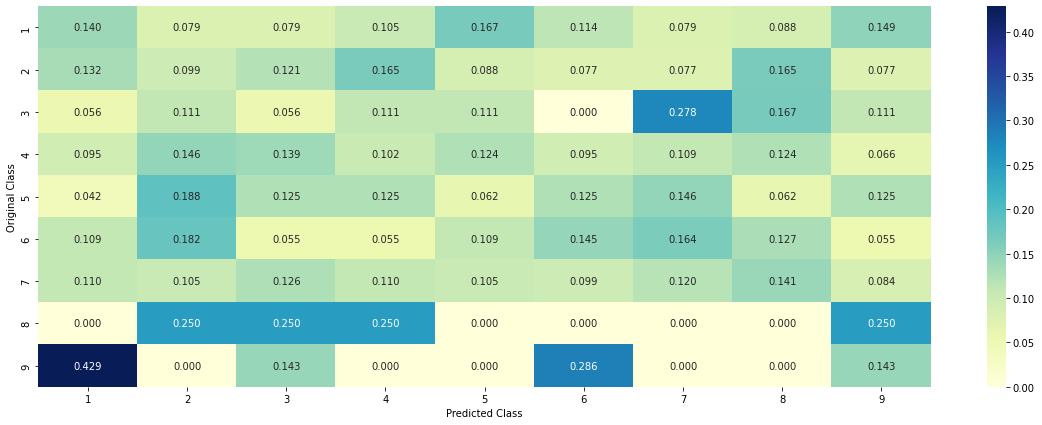

In [50]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## **Evaluating Gene Column**

Now we will look at each independent column to make sure its relavent for my target variable but the question is, how? Let's understand with our first column Gene which is categorial in nature.

So, lets explore column ***Gene*** and lets look at its distribution. 

In [51]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 229
BRCA1     181
TP53      102
EGFR       81
PTEN       77
BRCA2      74
KIT        70
BRAF       62
ALK        46
ERBB2      44
PIK3CA     36
Name: Gene, dtype: int64


Lets see the number of unique values present in gene

In [52]:
unique_genes.shape[0]

229

Lets look at the comulative distribution of unique Genes values

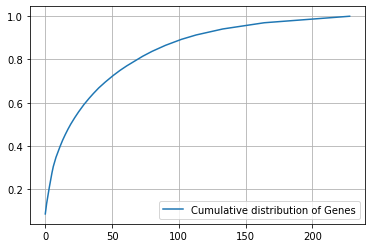

In [53]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

So, now we need to convert these categorical variable to appropirate format which my machine learning algorithm will be able to take as an input.

So we have 2 techniques to deal with it. 

- **One-hot encoding**
- **Response Encoding** (Mean imputation)

Let's use both of them to see which one work the best. So lets start encoding using one hot encoder

In [54]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

Let's check the number of column generated after one hot encoding. One hot encoding will always return higher number of column.

In [55]:
train_gene_feature_onehotCoding.shape

(2124, 229)

In [56]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gnaq',
 'gnas',
 'h3f3a',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'ikzf1',
 'inpp4b',
 'jak1',
 'jak2',
 'jun',
 'k

Now, lets also create Response encoding columns for Gene column

In [57]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [58]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Let's look at columns after applying response encoding. We must be having 9 columns for Gene column after response encoding.

In [59]:
train_gene_feature_responseCoding.shape

(2124, 9)

Now, question is how good is Gene column feature to predict my 9 classes. One idea could be that we will build model having only gene column with one hot encoder with simple model like Logistic regression. If log loss with only one column Gene comes out to be better than random model, than this feature is important.

In [60]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [61]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.1534953319062713
For values of alpha =  0.0001 The log loss is: 1.1117214681894425
For values of alpha =  0.001 The log loss is: 1.1375753611226154
For values of alpha =  0.01 The log loss is: 1.24983806841322
For values of alpha =  0.1 The log loss is: 1.4095446276112111
For values of alpha =  1 The log loss is: 1.4622779038617961


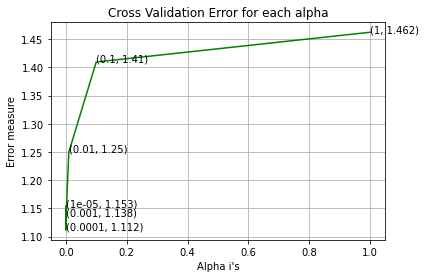

In [62]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [63]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 1.015102181784835
For values of best alpha =  0.0001 The cross validation log loss is: 1.1117214681894425
For values of best alpha =  0.0001 The test log loss is: 1.1823367156763742


Now lets check how many values are overlapping between train, test or between CV and train

In [64]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [65]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 644 out of 665 : 96.84210526315789
2. In cross validation data 511 out of  532 : 96.05263157894737


### **Evaluating Variation column**

Variation is also a categorical variable so we have to deal in same way like we have done for ***Gene*** column. We will again get the one hot encoder and response enoding variable for variation column.

In [66]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1928
Truncating_Mutations    59
Amplification           51
Deletion                47
Fusions                 21
G12V                     4
T58I                     3
Q61L                     3
R173C                    2
A146V                    2
Overexpression           2
Name: Variation, dtype: int64


Lets look at the comulative distribution of unique ***variation*** values

[0.02777778 0.05178908 0.07391714 ... 0.99905838 0.99952919 1.        ]


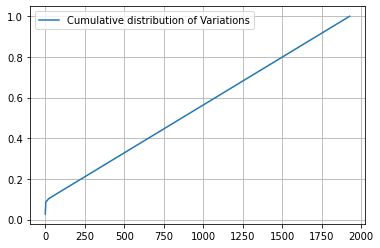

In [67]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Lets convert the variation column using one hot encoder column

In [68]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

Lets look at shape of one hot encoder column for variation

In [69]:
train_variation_feature_onehotCoding.shape

(2124, 1956)

Lets do the same for variation column and generate response encoding for the same.

In [70]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

Lets look at the shape of this response encoding result

In [71]:
train_variation_feature_responseCoding.shape

(2124, 9)

Lets again build the model with only column name of ***variation*** column

In [72]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [73]:
# We will be using SGD classifier
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7114321154189844
For values of alpha =  0.0001 The log loss is: 1.7066681572201134
For values of alpha =  0.001 The log loss is: 1.7081105090291488
For values of alpha =  0.01 The log loss is: 1.7160312060198033
For values of alpha =  0.1 The log loss is: 1.725225509394022
For values of alpha =  1 The log loss is: 1.7267856585994126


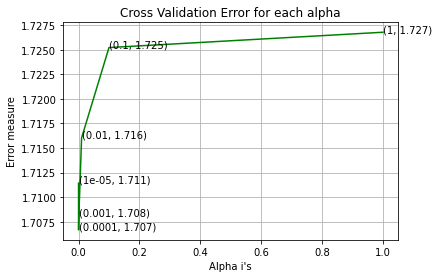

In [74]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [75]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.6593697311851393
For values of best alpha =  0.0001 The cross validation log loss is: 1.7066681572201134
For values of best alpha =  0.0001 The test log loss is: 1.722802366495619


In [76]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [77]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 64 out of 665 : 9.624060150375941
2. In cross validation data 57 out of  532 : 10.714285714285714


### **Evaluating Text column**

In [78]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [79]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [80]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54743


In [81]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [82]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [83]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [84]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [85]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [86]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5478, 4: 4196, 6: 2998, 5: 2633, 8: 2416, 7: 2135, 9: 1990, 10: 1420, 12: 1295, 11: 1087, 15: 988, 16: 918, 13: 875, 14: 858, 18: 732, 17: 646, 24: 576, 22: 537, 20: 507, 21: 502, 19: 475, 23: 468, 28: 423, 25: 382, 27: 352, 26: 348, 30: 346, 39: 337, 32: 310, 33: 292, 29: 292, 31: 290, 36: 280, 35: 253, 40: 250, 54: 243, 34: 236, 38: 206, 42: 201, 44: 192, 48: 191, 37: 188, 45: 187, 41: 187, 56: 180, 52: 176, 46: 160, 55: 157, 43: 157, 47: 150, 50: 149, 49: 145, 60: 144, 58: 135, 53: 135, 57: 132, 61: 130, 64: 124, 51: 123, 71: 115, 62: 111, 63: 110, 72: 109, 67: 108, 65: 107, 82: 104, 59: 102, 66: 100, 70: 98, 69: 97, 68: 87, 75: 86, 77: 84, 80: 82, 88: 79, 90: 76, 81: 75, 79: 75, 78: 75, 76: 75, 84: 74, 83: 74, 73: 71, 87: 69, 74: 69, 85: 68, 112: 67, 92: 67, 100: 65, 108: 64, 98: 64, 99: 63, 93: 63, 91: 62, 94: 61, 86: 60, 89: 59, 102: 58, 128: 56, 104: 52, 106: 51, 103: 51, 95: 51, 114: 50, 96: 50, 97: 49, 123: 48, 105: 48, 119: 46, 113: 46, 110: 46, 109: 46, 121: 43, 

Lets build the model with only ***text*** column

In [87]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.2673760207114788
For values of alpha =  0.0001 The log loss is: 1.0786885038611795
For values of alpha =  0.001 The log loss is: 1.0237322933843083
For values of alpha =  0.01 The log loss is: 1.1204373927615987
For values of alpha =  0.1 The log loss is: 1.3808470966071826
For values of alpha =  1 The log loss is: 1.6228483973931767


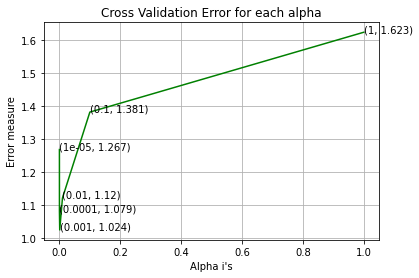

In [88]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [89]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6799493517862248
For values of best alpha =  0.001 The cross validation log loss is: 1.0237322933843083
For values of best alpha =  0.001 The test log loss is: 1.17643578920309


Lets check the overlap of text data

In [90]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [91]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.11 % of word of test data appeared in train data
98.159 % of word of Cross Validation appeared in train data


So, all 3 columns are going to be important.

### **Data prepration for Machine Learning models**

Lets create few functions which we will be using later

In [92]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [93]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [94]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### **Combining all 3 features together**

In [95]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [96]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56928)
(number of data points * number of features) in test data =  (665, 56928)
(number of data points * number of features) in cross validation data = (532, 56928)


In [97]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## **Building Machine Learning model**

Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.

### **Naive Bayes**

In [98]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.2389415306180895
for alpha = 0.0001
Log Loss : 1.2301209055200164
for alpha = 0.001
Log Loss : 1.2159119460409984
for alpha = 0.1
Log Loss : 1.1904204748660667
for alpha = 1
Log Loss : 1.233180293636637
for alpha = 10
Log Loss : 1.3464678978527922
for alpha = 100
Log Loss : 1.3140828715747617
for alpha = 1000
Log Loss : 1.2407077843951957


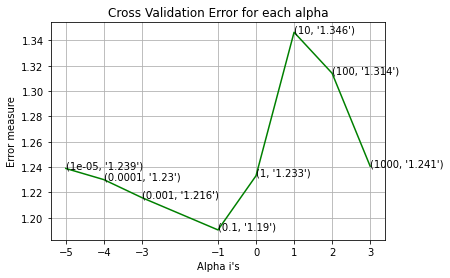

In [99]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [100]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.884148982766114
For values of best alpha =  0.1 The cross validation log loss is: 1.1904204748660667
For values of best alpha =  0.1 The test log loss is: 1.2874834198515697


Testing our Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.1904204748660667
Number of missclassified point : 0.35150375939849626
-------------------- Confusion matrix --------------------


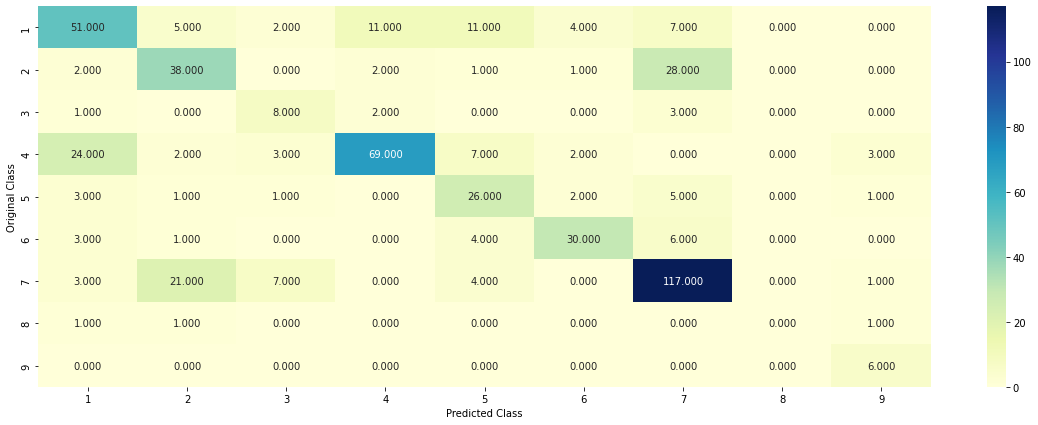

-------------------- Precision matrix (Columm Sum=1) --------------------


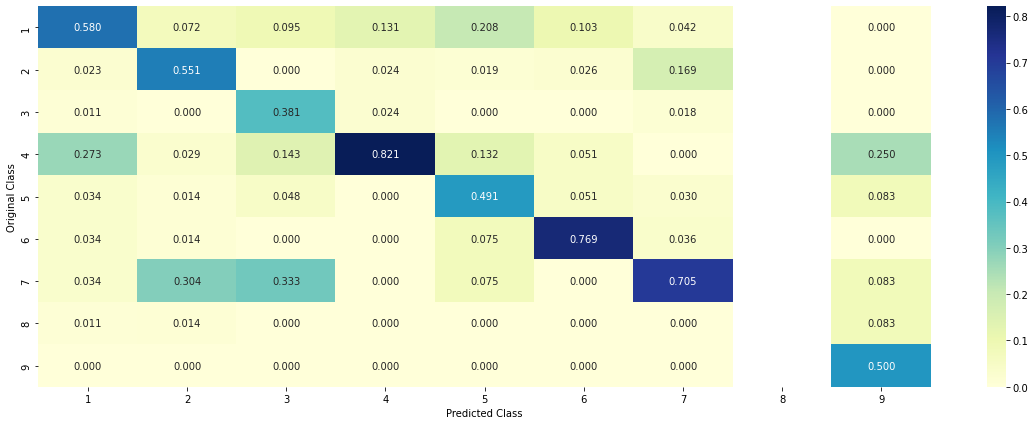

-------------------- Recall matrix (Row sum=1) --------------------


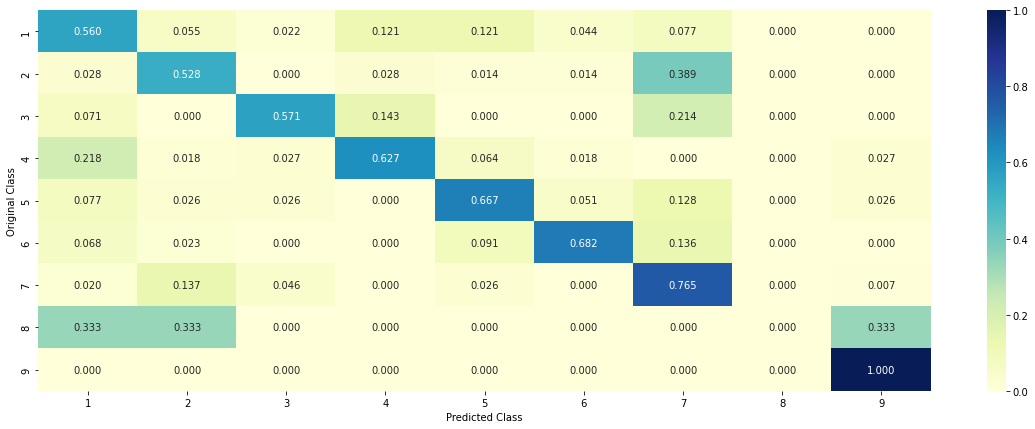

In [101]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### **Interpretability of our model**

In [102]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0842 0.0744 0.0137 0.1024 0.0324 0.0336 0.6502 0.0049 0.0041]]
Actual Class : 7
--------------------------------------------------
14 Text feature [kinase] present in test data point [True]
15 Text feature [downstream] present in test data point [True]
16 Text feature [well] present in test data point [True]
17 Text feature [presence] present in test data point [True]
18 Text feature [independent] present in test data point [True]
19 Text feature [cell] present in test data point [True]
20 Text feature [activating] present in test data point [True]
21 Text feature [inhibitor] present in test data point [True]
22 Text feature [potential] present in test data point [True]
23 Text feature [previously] present in test data point [True]
24 Text feature [contrast] present in test data point [True]
25 Text feature [found] present in test data point [True]
26 Text feature [cells] present in test data point [True]
27 Text feature [showed] p

Lets look at one more point

In [103]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0842 0.0744 0.0137 0.1024 0.0324 0.0336 0.6502 0.0049 0.0041]]
Actual Class : 7
--------------------------------------------------
14 Text feature [kinase] present in test data point [True]
15 Text feature [downstream] present in test data point [True]
16 Text feature [well] present in test data point [True]
17 Text feature [presence] present in test data point [True]
18 Text feature [independent] present in test data point [True]
19 Text feature [cell] present in test data point [True]
20 Text feature [activating] present in test data point [True]
21 Text feature [inhibitor] present in test data point [True]
22 Text feature [potential] present in test data point [True]
23 Text feature [previously] present in test data point [True]
24 Text feature [contrast] present in test data point [True]
25 Text feature [found] present in test data point [True]
26 Text feature [cells] present in test data point [True]
27 Text feature [showed] p

So Naive Bayes not performing very badly but lets look at other models

## **K Nearest Neighbour Classification**

In [104]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 0.9533755257642789
for alpha = 11
Log Loss : 0.9441809533704059
for alpha = 15
Log Loss : 0.9435171776397445
for alpha = 21
Log Loss : 0.9432246090996221
for alpha = 31
Log Loss : 0.9345921530021719
for alpha = 41
Log Loss : 0.9321312350824621
for alpha = 51
Log Loss : 0.941438969622528
for alpha = 99
Log Loss : 0.9891138477682446


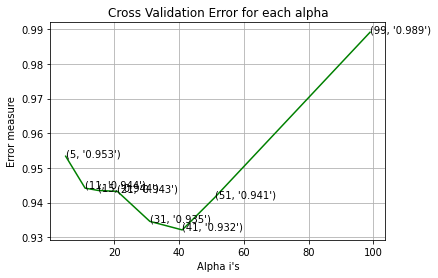

In [105]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [106]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  41 The train log loss is: 0.864705347641509
For values of best alpha =  41 The cross validation log loss is: 0.9321312350824621
For values of best alpha =  41 The test log loss is: 1.1010132859287967


Let's test it on testing dataset with our best alpha value

Log loss : 0.9321312350824621
Number of mis-classified points : 0.32706766917293234
-------------------- Confusion matrix --------------------


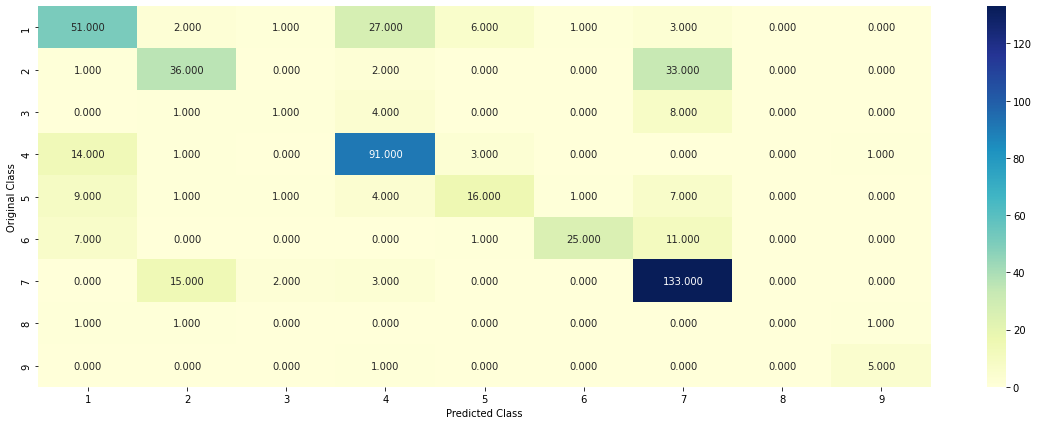

-------------------- Precision matrix (Columm Sum=1) --------------------


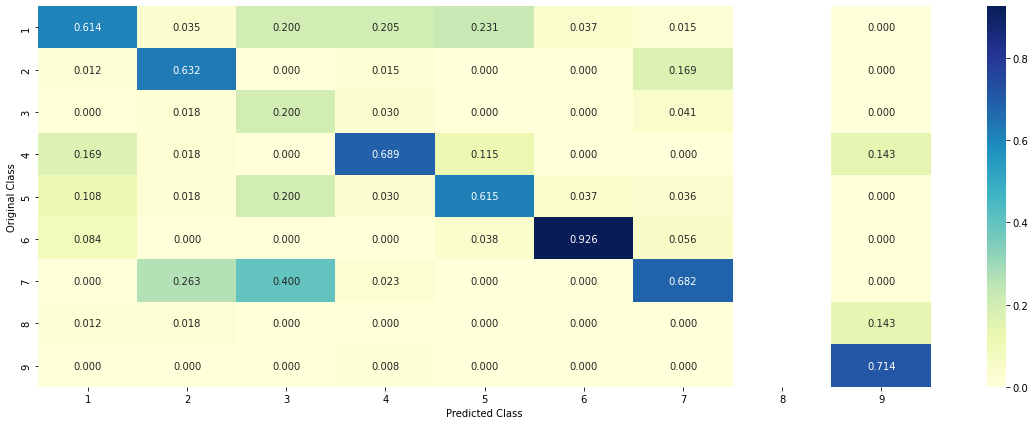

-------------------- Recall matrix (Row sum=1) --------------------


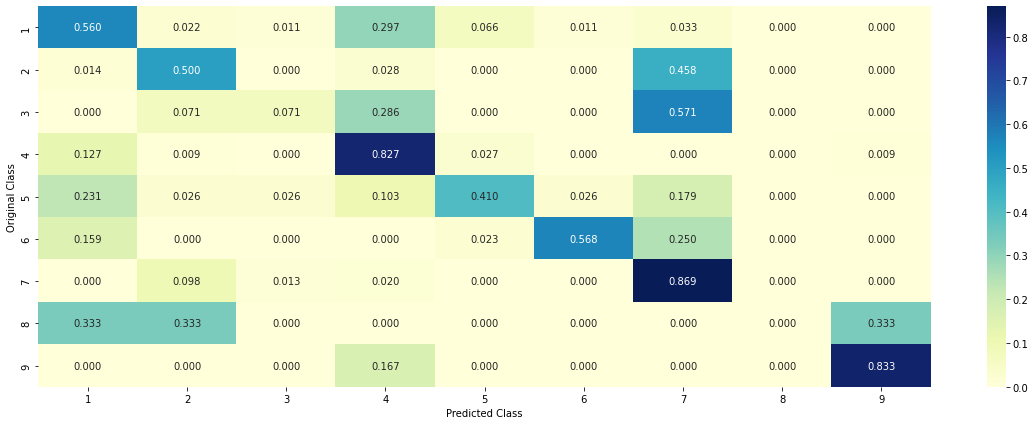

In [107]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [108]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  41  nearest neighbours of the test points belongs to classes [7 7 7 7 2 7 7 7 7 7 5 2 7 2 2 7 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 2
 2 2 2 7]
Fequency of nearest points : Counter({7: 30, 2: 9, 5: 1, 4: 1})


In [109]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 41 and the nearest neighbours of the test points belongs to classes [2 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 2 2 7 2 7 7 2 7 7 7 7 7 2 7 5 2 2 7 7 7
 7 2 7 8]
Fequency of nearest points : Counter({7: 29, 2: 10, 5: 1, 8: 1})


## **Logistic Regression**

### **Balancing all classes**

In [110]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.2897024751129573
for alpha = 1e-05
Log Loss : 1.2456509781211975
for alpha = 0.0001
Log Loss : 1.040027430193114
for alpha = 0.001
Log Loss : 0.9792674925367735
for alpha = 0.01
Log Loss : 1.0260956297301833
for alpha = 0.1
Log Loss : 1.3790412639906402
for alpha = 1
Log Loss : 1.6385544007108381
for alpha = 10
Log Loss : 1.6695985191988825
for alpha = 100
Log Loss : 1.6728337954199493


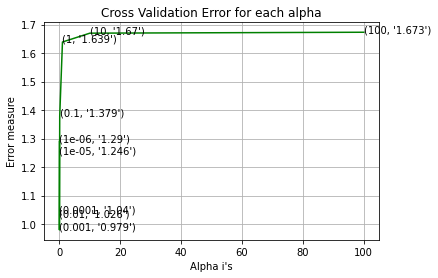

In [111]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [112]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5497823520676646
For values of best alpha =  0.001 The cross validation log loss is: 0.9792674925367735
For values of best alpha =  0.001 The test log loss is: 1.0967828985622932


Lets test it on testing data using best alpha value

Log loss : 0.9792674925367735
Number of mis-classified points : 0.3082706766917293
-------------------- Confusion matrix --------------------


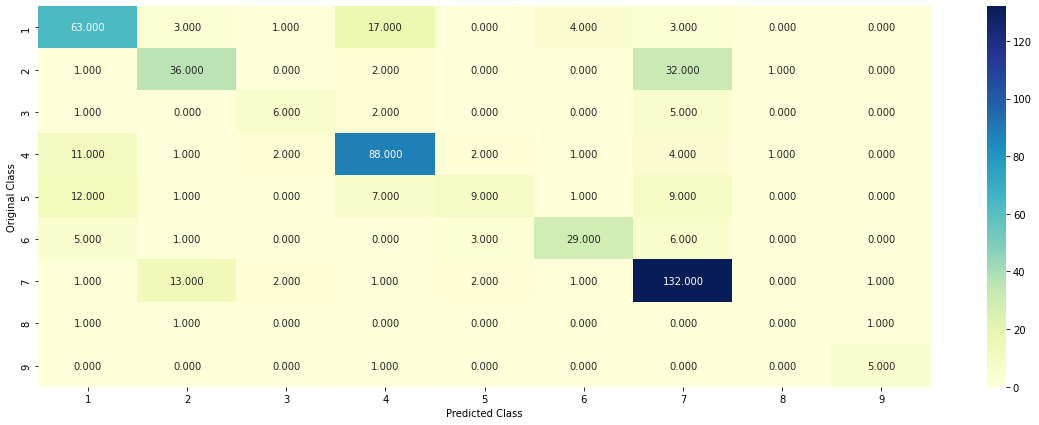

-------------------- Precision matrix (Columm Sum=1) --------------------


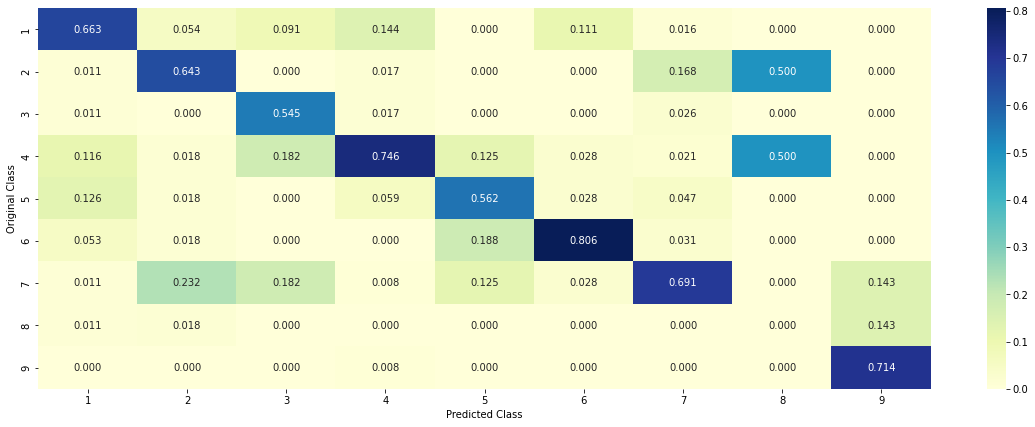

-------------------- Recall matrix (Row sum=1) --------------------


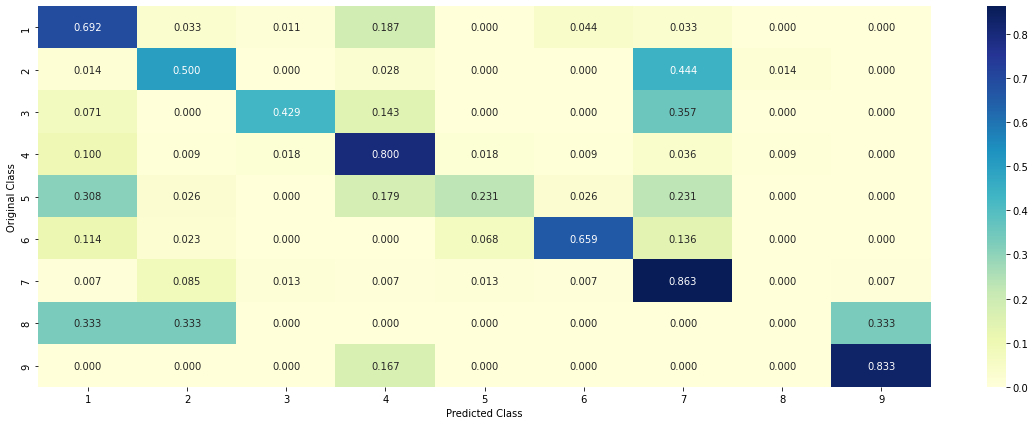

In [113]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### **Feature importance**

In [114]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

testing query point and doing interpretability

In [115]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[3.000e-04 3.240e-02 0.000e+00 0.000e+00 1.000e-04 0.000e+00 9.544e-01
  1.220e-02 6.000e-04]]
Actual Class : 7
--------------------------------------------------
50 Text feature [constitutively] present in test data point [True]
51 Text feature [transforming] present in test data point [True]
53 Text feature [activated] present in test data point [True]
58 Text feature [ligand] present in test data point [True]
61 Text feature [stat] present in test data point [True]
72 Text feature [egfrs] present in test data point [True]
81 Text feature [mitogen] present in test data point [True]
109 Text feature [transformation] present in test data point [True]
113 Text feature [tk] present in test data point [True]
118 Text feature [oncogene] present in test data point [True]
135 Text feature [expressing] present in test data point [True]
137 Text feature [transformed] present in test data point [True]
139 Text feature [3t3] present in test dat

In [116]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0083 0.1234 0.001  0.0117 0.0052 0.0032 0.836  0.0086 0.0026]]
Actual Class : 7
--------------------------------------------------
23 Text feature [constitutive] present in test data point [True]
51 Text feature [transforming] present in test data point [True]
53 Text feature [activated] present in test data point [True]
54 Text feature [stat5] present in test data point [True]
58 Text feature [ligand] present in test data point [True]
72 Text feature [egfrs] present in test data point [True]
100 Text feature [technology] present in test data point [True]
113 Text feature [tk] present in test data point [True]
137 Text feature [transformed] present in test data point [True]
139 Text feature [3t3] present in test data point [True]
150 Text feature [downstream] present in test data point [True]
158 Text feature [hki] present in test data point [True]
166 Text feature [receptors] present in test data point [True]
172 Text feature [act

### **Without class balancing**

In [117]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.2646514541853875
for alpha = 1e-05
Log Loss : 1.2262103507205049
for alpha = 0.0001
Log Loss : 1.0427503314700666
for alpha = 0.001
Log Loss : 0.9834243779051113
for alpha = 0.01
Log Loss : 1.0598418363966926
for alpha = 0.1
Log Loss : 1.291312274683213
for alpha = 1
Log Loss : 1.559912705985938


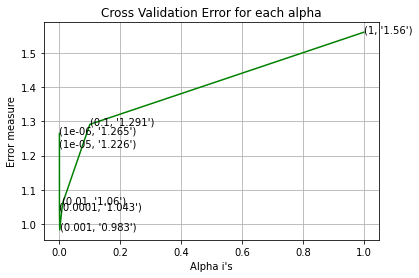

In [118]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [119]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5436817477695935
For values of best alpha =  0.001 The cross validation log loss is: 0.9834243779051113
For values of best alpha =  0.001 The test log loss is: 1.111500827919902


Lets test our model with best hyper param

Log loss : 0.9834243779051113
Number of mis-classified points : 0.29887218045112784
-------------------- Confusion matrix --------------------


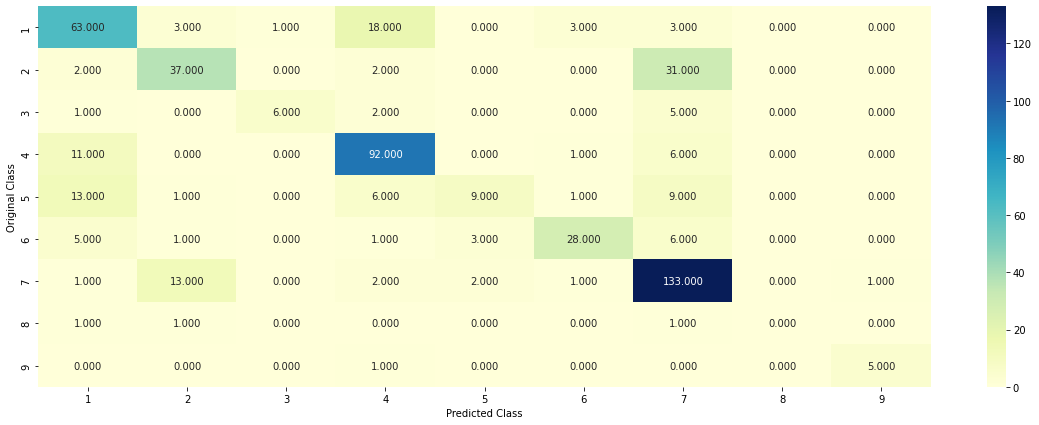

-------------------- Precision matrix (Columm Sum=1) --------------------


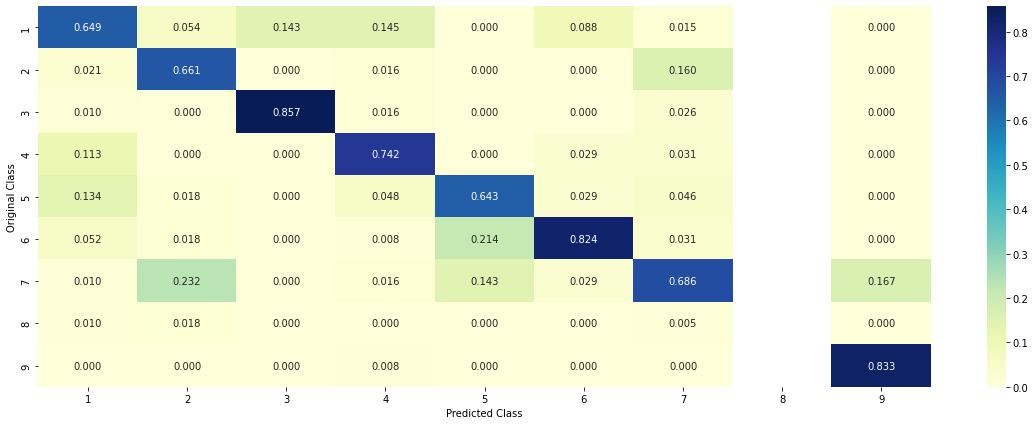

-------------------- Recall matrix (Row sum=1) --------------------


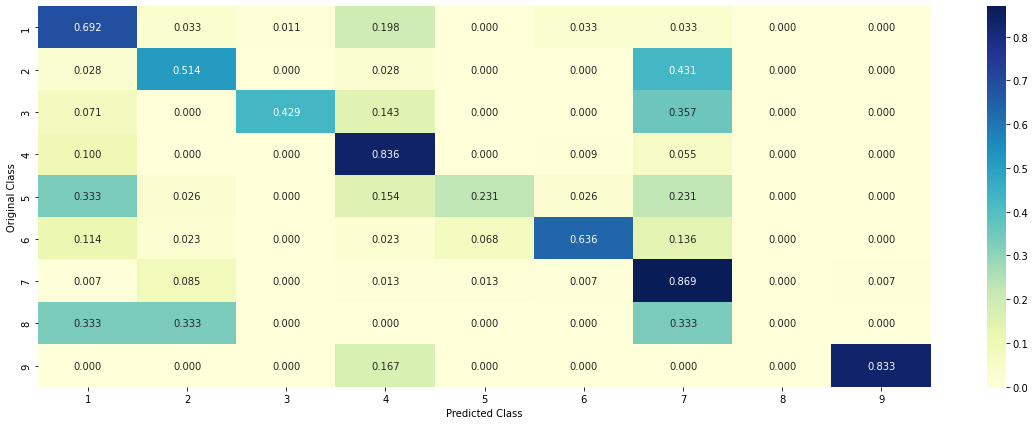

In [120]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### **Testing query point and interpretability**

In [121]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[4.000e-04 3.840e-02 0.000e+00 1.000e-04 1.000e-04 0.000e+00 9.555e-01
  5.600e-03 0.000e+00]]
Actual Class : 7
--------------------------------------------------
109 Text feature [transforming] present in test data point [True]
117 Text feature [constitutively] present in test data point [True]
125 Text feature [stat] present in test data point [True]
126 Text feature [activated] present in test data point [True]
133 Text feature [ligand] present in test data point [True]
162 Text feature [hki] present in test data point [True]
169 Text feature [mitogen] present in test data point [True]
185 Text feature [transformation] present in test data point [True]
192 Text feature [egfrs] present in test data point [True]
215 Text feature [expressing] present in test data point [True]
251 Text feature [activating] present in test data point [True]
260 Text feature [tk] present in test data point [True]
268 Text feature [transformed] present in

## **Linear Support Vector Machines**

for C = 1e-05
Log Loss : 1.2672037357782158
for C = 0.0001
Log Loss : 1.1709657858232798
for C = 0.001
Log Loss : 1.069734364188934
for C = 0.01
Log Loss : 1.0588439837061738
for C = 0.1
Log Loss : 1.2869098949463584
for C = 1
Log Loss : 1.6619775069892817
for C = 10
Log Loss : 1.673420499212737
for C = 100
Log Loss : 1.6734323788777499


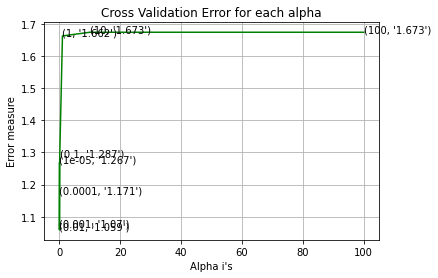

For values of best alpha =  0.01 The train log loss is: 0.7593498614312797
For values of best alpha =  0.01 The cross validation log loss is: 1.0588439837061738
For values of best alpha =  0.01 The test log loss is: 1.1950822557668939


In [122]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### **Testing model with best alpha values**

Log loss : 1.0588439837061738
Number of mis-classified points : 0.33646616541353386
-------------------- Confusion matrix --------------------


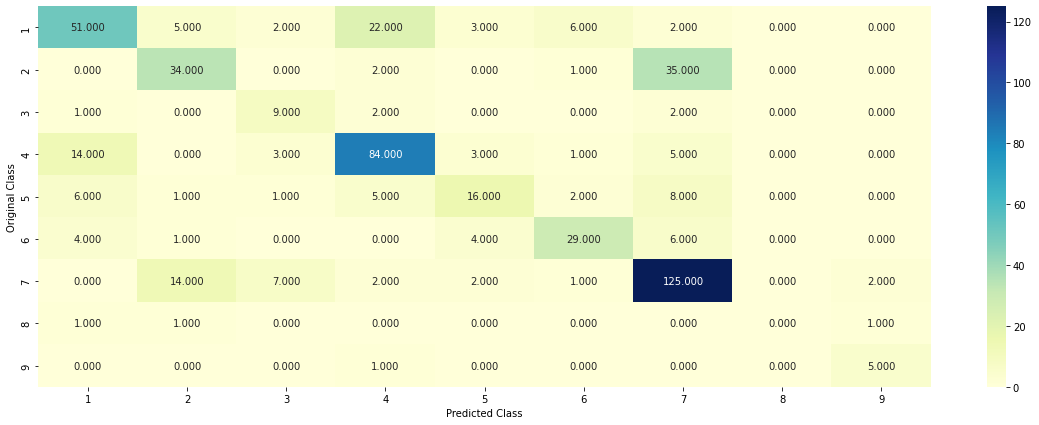

-------------------- Precision matrix (Columm Sum=1) --------------------


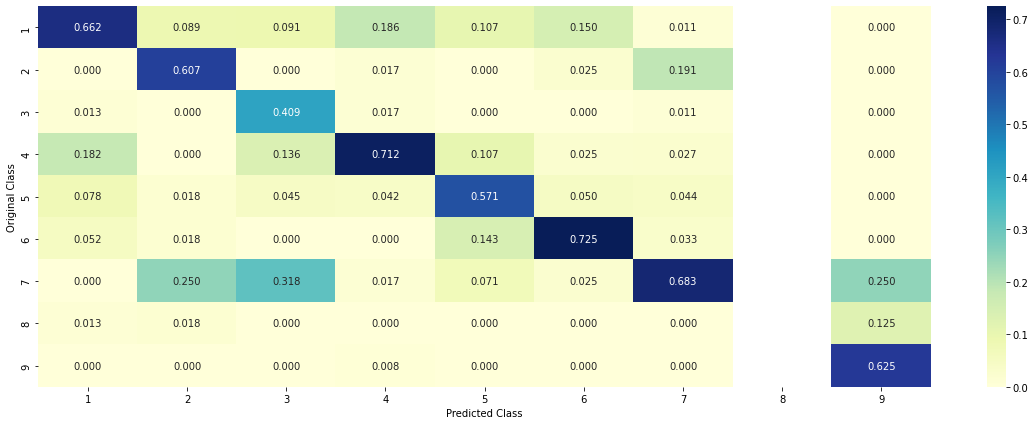

-------------------- Recall matrix (Row sum=1) --------------------


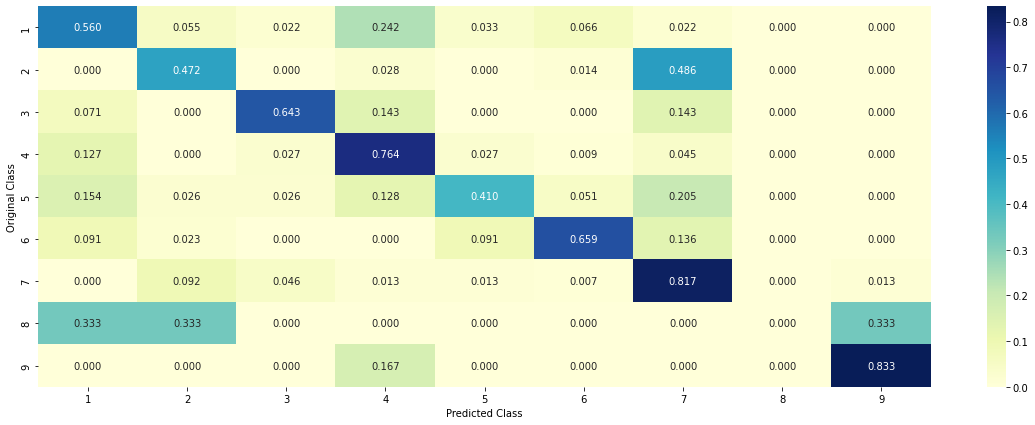

In [123]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

Querying some correctly classified point

In [124]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.850e-02 2.050e-02 5.000e-04 2.500e-03 1.500e-03 2.200e-03 9.397e-01
  1.430e-02 2.000e-04]]
Actual Class : 7
--------------------------------------------------
37 Text feature [transforming] present in test data point [True]
38 Text feature [stat] present in test data point [True]
56 Text feature [cdnas] present in test data point [True]
65 Text feature [ligand] present in test data point [True]
71 Text feature [3t3] present in test data point [True]
76 Text feature [expressing] present in test data point [True]
96 Text feature [constitutively] present in test data point [True]
99 Text feature [mitogen] present in test data point [True]
101 Text feature [egfrs] present in test data point [True]
110 Text feature [activated] present in test data point [True]
136 Text feature [transformation] present in test data point [True]
149 Text feature [transformed] present in test data point [True]
160 Text feature [concentrations] present in 

## **Random Forest Classifier**

### **Model with One hot encoder**

In [125]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.215212796210815
for n_estimators = 100 and max depth =  10
Log Loss : 1.1482332027109414
for n_estimators = 200 and max depth =  5
Log Loss : 1.2081679884736019
for n_estimators = 200 and max depth =  10
Log Loss : 1.1356901843381395
for n_estimators = 500 and max depth =  5
Log Loss : 1.204576262573988
for n_estimators = 500 and max depth =  10
Log Loss : 1.1321124660658013
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2039939543363605
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1310964736923985
for n_estimators = 2000 and max depth =  5
Log Loss : 1.203022101402892
for n_estimators = 2000 and max depth =  10
Log Loss : 1.127223518500923


In [126]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.6667104259337787
For values of best estimator =  2000 The cross validation log loss is: 1.127223518500923
For values of best estimator =  2000 The test log loss is: 1.162809193547805


Lets test it on testing data using best hyper param

Log loss : 1.127223518500923
Number of mis-classified points : 0.38533834586466165
-------------------- Confusion matrix --------------------


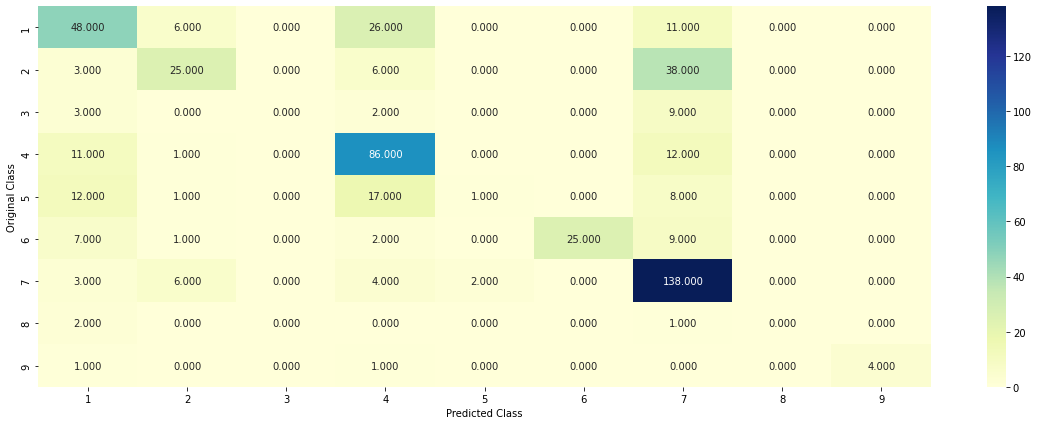

-------------------- Precision matrix (Columm Sum=1) --------------------


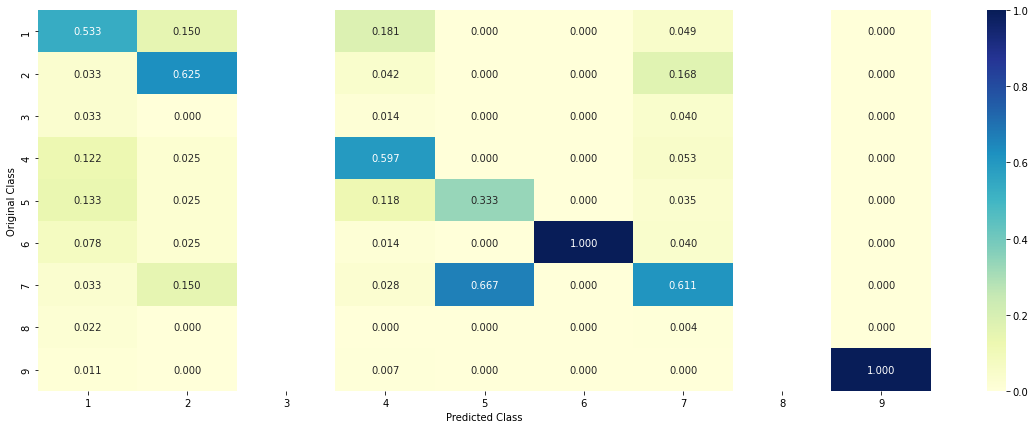

-------------------- Recall matrix (Row sum=1) --------------------


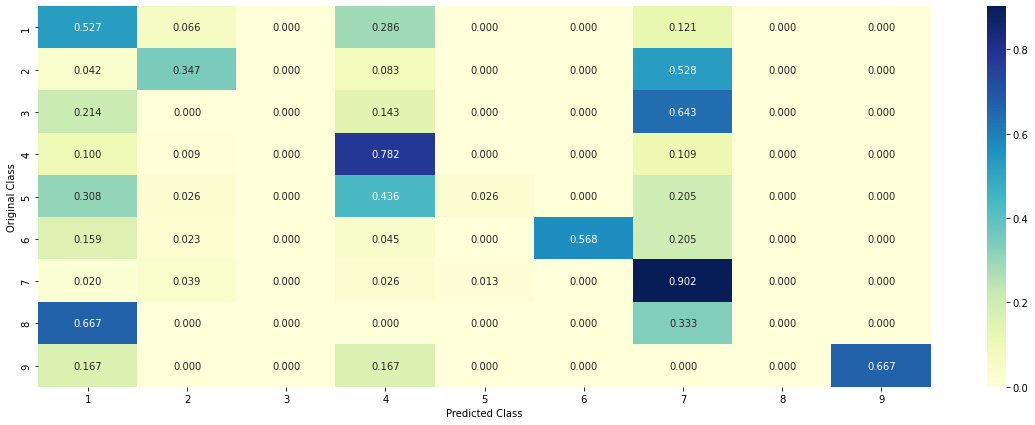

In [127]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [128]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0212 0.1441 0.0135 0.0152 0.0251 0.0236 0.7496 0.0046 0.0032]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [inhibitors] present in test data point [True]
4 Text feature [activated] present in test data point [True]
5 Text feature [tyrosine] present in test data point [True]
6 Text feature [missense] present in test data point [True]
7 Text feature [activation] present in test data point [True]
8 Text feature [suppressor] present in test data point [True]
9 Text feature [function] present in test data point [True]
10 Text feature [receptor] present in test data point [True]
12 Text feature [phosphorylation] present in test data point [True]
13 Text feature [oncogenic] present in test data point [True]
14 Text feature [inhibitor] present in test data point [True]
15 Text featur

### **RF with Response Coding**

In [129]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0118912283375185
for n_estimators = 10 and max depth =  3
Log Loss : 1.6529124313169092
for n_estimators = 10 and max depth =  5
Log Loss : 1.3679706150551199
for n_estimators = 10 and max depth =  10
Log Loss : 1.8911915701582045
for n_estimators = 50 and max depth =  2
Log Loss : 1.6445446264340575
for n_estimators = 50 and max depth =  3
Log Loss : 1.3991993101931497
for n_estimators = 50 and max depth =  5
Log Loss : 1.2450649669167742
for n_estimators = 50 and max depth =  10
Log Loss : 1.7835709304948801
for n_estimators = 100 and max depth =  2
Log Loss : 1.4385999732392565
for n_estimators = 100 and max depth =  3
Log Loss : 1.4187683298876805
for n_estimators = 100 and max depth =  5
Log Loss : 1.2260155858917696
for n_estimators = 100 and max depth =  10
Log Loss : 1.7749552121594487
for n_estimators = 200 and max depth =  2
Log Loss : 1.4701895921459358
for n_estimators = 200 and max depth =  3
Log Loss : 1.41645462185135

Testing model with best hyper param

Log loss : 1.2260155858917694
Number of mis-classified points : 0.41353383458646614
-------------------- Confusion matrix --------------------


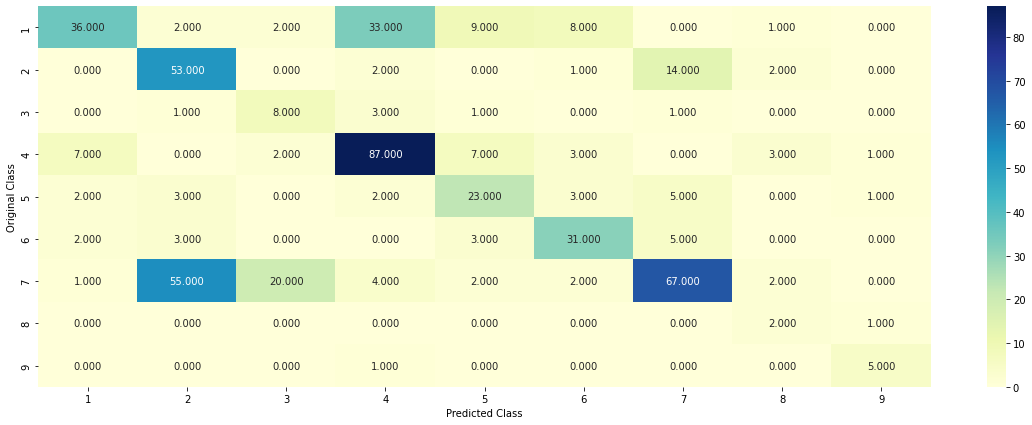

-------------------- Precision matrix (Columm Sum=1) --------------------


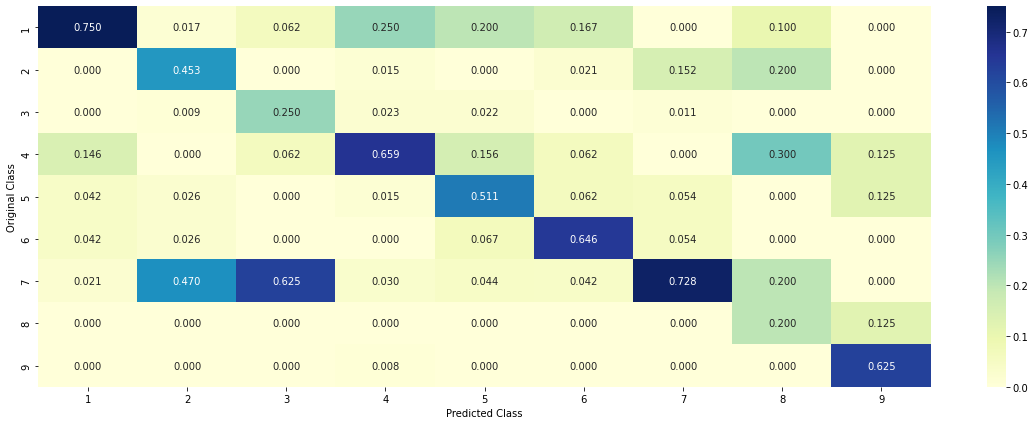

-------------------- Recall matrix (Row sum=1) --------------------


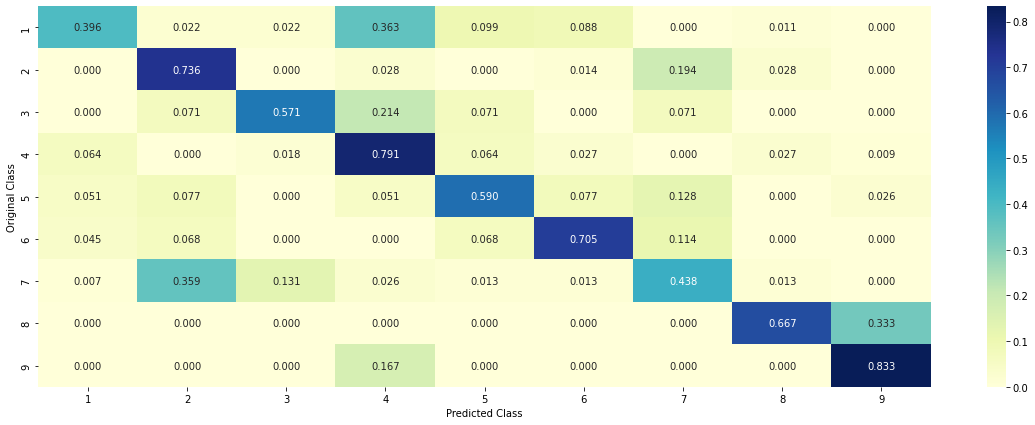

In [130]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

Query the classified point

In [131]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0158 0.3432 0.1155 0.0246 0.0411 0.0429 0.3181 0.082  0.0168]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## **Stacking model**

In [132]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.98
Support vector machines : Log Loss: 1.66
Naive Bayes : Log Loss: 1.22
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.724
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.311
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.057
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.230
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.560


Testing with best hyper param

Log loss (train) on the stacking classifier : 0.5089373719091987
Log loss (CV) on the stacking classifier : 1.0565468105976814
Log loss (test) on the stacking classifier : 1.2101335265793067
Number of missclassified point : 0.3849624060150376
-------------------- Confusion matrix --------------------


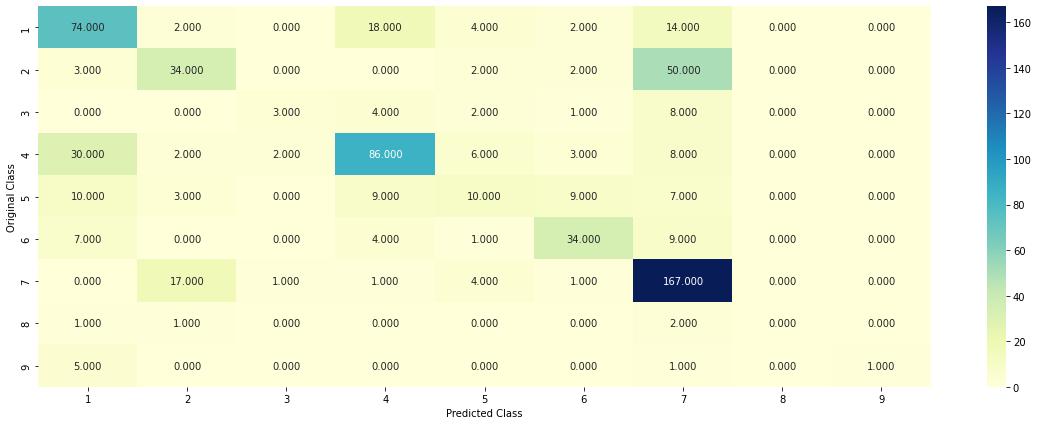

-------------------- Precision matrix (Columm Sum=1) --------------------


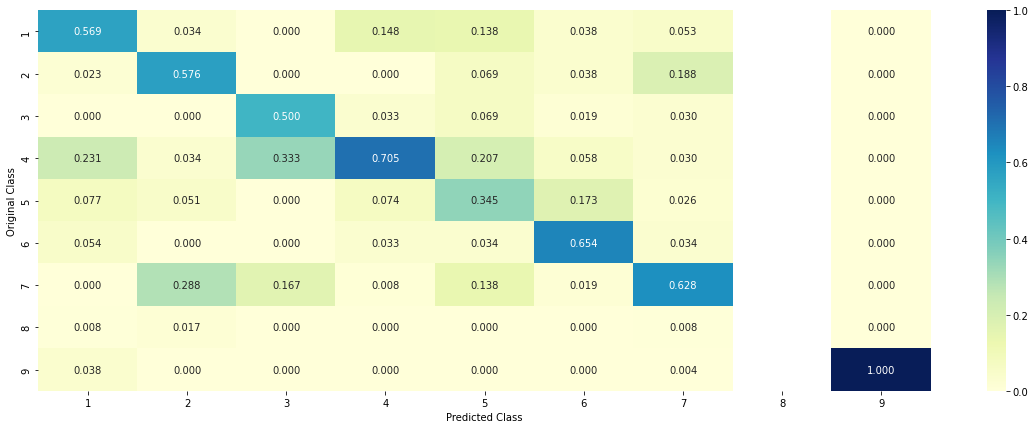

-------------------- Recall matrix (Row sum=1) --------------------


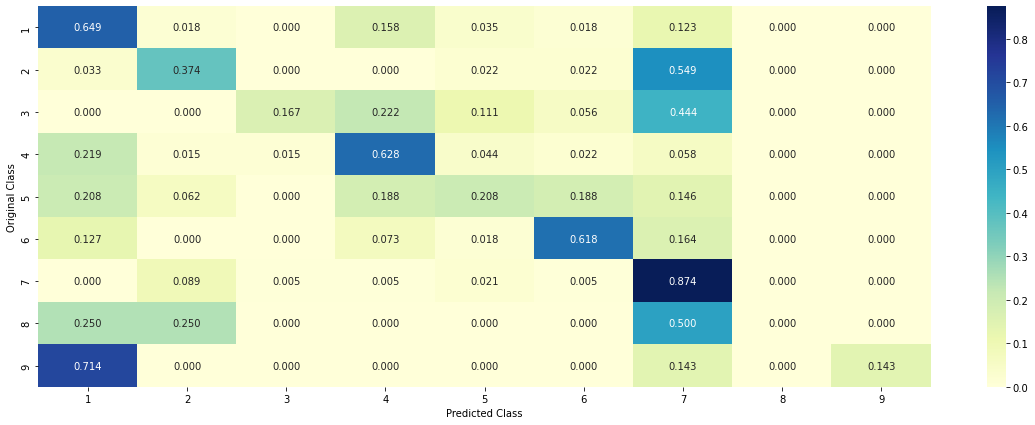

In [133]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## **Maximum voting Classifier**

Log loss (train) on the VotingClassifier : 0.8866074452546199
Log loss (CV) on the VotingClassifier : 1.1353600039477225
Log loss (test) on the VotingClassifier : 1.2168044821446022
Number of missclassified point : 0.3804511278195489
-------------------- Confusion matrix --------------------


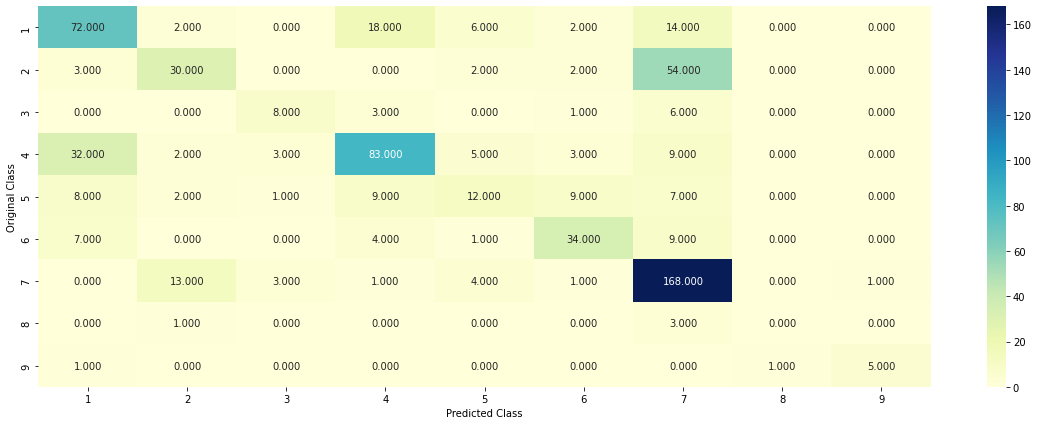

-------------------- Precision matrix (Columm Sum=1) --------------------


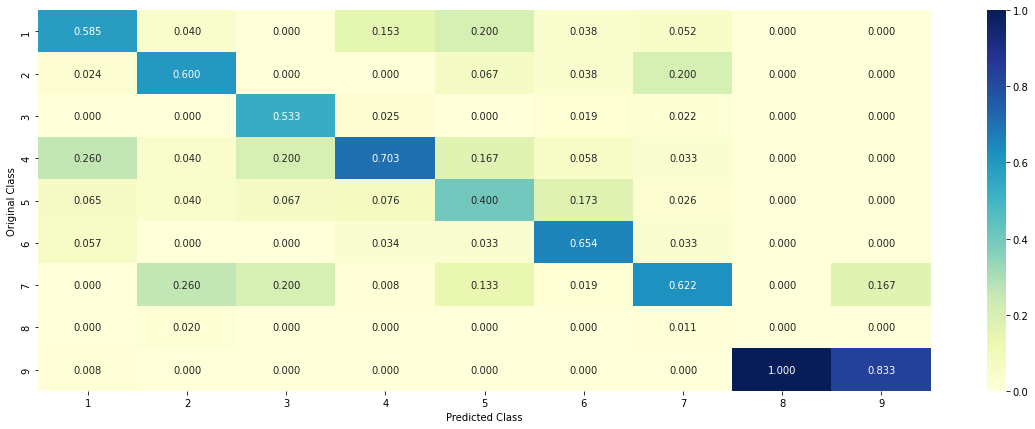

-------------------- Recall matrix (Row sum=1) --------------------


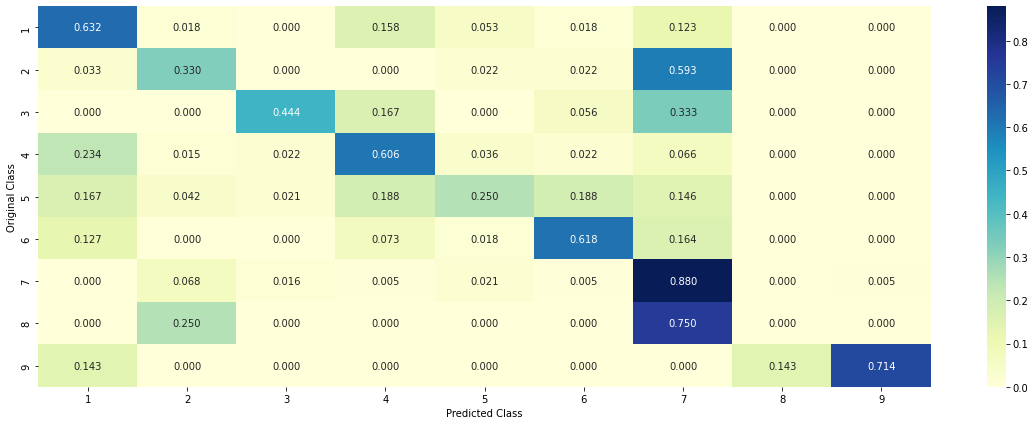

In [134]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))